## Import necessary libraries


In the following code, we are setting up the environment by importing required libraries.
- `openml` for accessing datasets from the OpenML repository.
- `time` for handling time-related operations.
- `jax` for high-performance numerical computing.
- `matplotlib.pyplot` for plotting graphs.
- Various JAX modules for specific functionalities like gradient computation, random number generation, etc.
- `typing` for type hinting.
- `IPython.display.Markdown` for displaying Markdown content in IPython.
- `tqdm.auto.trange` for creating a tqdm progress bar.

The variable `SEED` is set to 404 for seeding random number generators, ensuring reproducibility.


In [1]:
import openml
import time
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt
import numpy as np
from typing import Union, Tuple, Iterable, List
from IPython.display import Markdown
from tqdm.auto import trange

# Set a seed for reproducibility
SEED = 404

## Exploring the MNIST Dataset for Machine Learning

In this code snippet, we delve into the MNIST dataset using the OpenML library. The MNIST dataset is a collection of handwritten digits widely used in machine learning and computer vision. Let's break down the steps:

1. [**Fetching the Dataset:**](#fetching-the-dataset)
   We use OpenML to retrieve the MNIST dataset, a crucial resource for developing and testing machine learning models. The dataset comprises images of handwritten digits, each labeled with its corresponding numeric value.

2. [**Extracting Features and Labels:**](#extracting-features-and-labels)
   With the fetched dataset, we extract the features (X) and labels (y). The features represent the pixel values of the handwritten digits, while the labels indicate the numeric values they represent. This step is fundamental for training machine learning models.

3. [**Data Preparation:**](#data-preparation)
   To ensure data compatibility, we convert the label data to integers. This step is essential for downstream tasks like model training, where proper data types are crucial.

The provided code offers a concise way to access and understand the MNIST dataset, laying the groundwork for future machine learning endeavors. Stay tuned for further exploration and analysis!


### Fetching the Dataset

In [2]:
# Import dataset ' MNIST '
dataset = openml.datasets.get_dataset(dataset_id=554, 
                                      download_data=False, 
                                      download_qualities=False, 
                                      download_features_meta_data=False)
Markdown(dataset.description)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.  

With some classification methods (particularly template-based methods, such as SVM and K-nearest neighbors), the error rate improves when the digits are centered by bounding box rather than center of mass. If you do this kind of pre-processing, you should report it in your publications. The MNIST database was constructed from NIST's NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found on the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.  

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. Our test set was composed of 5,000 patterns from SD-3 and 5,000 patterns from SD-1. The 60,000 pattern training set contained examples from approximately 250 writers. We made sure that the sets of writers of the training set and test set were disjoint. SD-1 contains 58,527 digit images written by 500 different writers. In contrast to SD-3, where blocks of data from each writer appeared in sequence, the data in SD-1 is scrambled. Writer identities for SD-1 is available and we used this information to unscramble the writers. We then split SD-1 in two: characters written by the first 250 writers went into our new training set. The remaining 250 writers were placed in our test set. Thus we had two sets with nearly 30,000 examples each. The new training set was completed with enough examples from SD-3, starting at pattern # 0, to make a full set of 60,000 training patterns. Similarly, the new test set was completed with SD-3 examples starting at pattern # 35,000 to make a full set with 60,000 test patterns. Only a subset of 10,000 test images (5,000 from SD-1 and 5,000 from SD-3) is available on this site. The full 60,000 sample training set is available.

### Extracting Features and Labels

In [3]:
# Extract features (X) and target variable (y) from the MNIST dataset
X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute, 
                                    dataset_format="dataframe")

# Ensure the target variable is of integer type
y = y.astype(int)

### Data Preparation

In [4]:
print(f'Feature shape:{X.shape}')
print(f'Label shape:{y.shape}')


Feature shape:(70000, 784)
Label shape:(70000,)


In [5]:
# Set the number of examples for training and testing follow dataset.description
train_size = 60000
test_size = 10000

# Split the data manually
X_train, X_test = X.iloc[:train_size, :].to_numpy(), X.iloc[train_size:train_size + test_size, :].to_numpy()
y_train, y_test = y.iloc[:train_size].to_numpy(), y.iloc[train_size:train_size + test_size].to_numpy()

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (60000, 784)
X_test shape: (10000, 784)
y_train shape: (60000,)
y_test shape: (10000,)


## Building and Training a Neural Network with JAX

In this step, we implement a simple neural network using the JAX library, a powerful tool for high-performance numerical computing. Let's break down the code:

### 1. Initializing Network Parameters
   - `random_layer_params(m, n, key, scale=1e-2)`: Helper function to randomly initialize weights and biases for a dense neural network layer.
   - `init_network_params(sizes, key)`: Initializes all layers for a fully-connected neural network with specified sizes.


In [6]:
# A helper function to randomly initialize weights and biases for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2) -> Tuple:
    """
    Args:
    - m (int): Number of input neurons.
    - n (int): Number of output neurons.
    - key (jax.random.PRNGKey): Random key for reproducibility.
    - scale (float): Scaling factor for weight and bias initialization.

    Returns:
    - Tuple: Tuple containing weight and bias arrays.
    """
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))


# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key) -> List[Tuple]:
    """
    Args:
    - sizes (List[int]): List of layer sizes.
    - key (jax.random.PRNGKey): Random key for reproducibility.

    Returns:
    - List[Tuple]: List of tuples containing weight and bias arrays for each layer.
    """
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


### 2. Activation Function
   - `relu(x)`: Rectified Linear Unit (ReLU) activation function applied element-wise.


In [7]:
def relu(x):
    """
    Args:
    - x (array): Input array.

    Returns:
    - array: Output array after applying ReLU activation function.
    """
    return jnp.maximum(0, x)


### 3. Prediction and Batch Processing
   - `predict(params, image)`: Makes per-example predictions using the initialized parameters.
   - `batched_predict(params, images)`: A batched version of the `predict` function using JAX's `vmap` for efficient processing.


In [8]:
from jax.scipy.special import logsumexp # Compute the log of the sum of exponentials of input elements
def predict(params, image):
    """
    Predicts output given input using a fully-connected neural network.

    Args:
    - params (List[Tuple]): List of tuples containing weight and bias arrays for each layer.
    - image (array): Input data.

    Returns:
    - array: Predicted logits.
    """
    # per-example predictions
    activations = image
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)
  
    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits)

# Make a batched version of the `predict` function
batched_predict = vmap(predict, in_axes=(None, 0))

### 4. One-Hot Encoding
   - `one_hot(x, k)`: Creates a one-hot encoding of input labels.

In [9]:
def one_hot(x, k):
    """
    Create a one-hot encoding of x of size k.

    Args:
    - x (array): Input array of integer labels.
    - k (int): Number of classes.

    Returns:
    - array: One-hot encoded array.
    """
    return jax.nn.one_hot(x, k)

### 5. Evaluation Metrics
   - `accuracy(params, images, targets)`: Computes accuracy of predictions.
   - `loss_fn(params, images, targets)`: Computes the cross-entropy loss.


In [10]:
def accuracy(params, images, targets):
    """
    Compute accuracy of predictions.

    Args:
    - params (List[Tuple]): List of tuples containing weight and bias arrays for each layer.
    - images (array): Input data.
    - targets (array): Target labels.

    Returns:
    - float: Accuracy.
    """
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(batched_predict(params, images), axis=1)
    return jnp.mean(predicted_class == target_class)

def loss_fn(params, images, targets):
    """
    Compute the cross-entropy loss.

    Args:
    - params (List[Tuple]): List of tuples containing weight and bias arrays for each layer.
    - images (array): Input data.
    - targets (array): Target labels.

    Returns:
    - float: Cross-entropy loss.
    """
    preds = batched_predict(params, images)
    return -jnp.mean(preds * targets)

### 6. Model Parameter Update
   - `update(params, x, y, lr=1e-4)`: Updates model parameters using gradient descent. The `@jit` decorator optimizes the function for performance.


In [11]:
@jit
def update(params, x, y, lr=1e-4):
    """
    Update the model parameters using gradient descent.

    Args:
    - params (List[Tuple]): List of tuples containing weight and bias arrays for each layer.
    - x (array): Input data.
    - y (array): Target labels.
    - lr (float): Learning rate for gradient descent.

    Returns:
    - List[Tuple]: Updated model parameters.
    """
    grads = grad(loss_fn)(params, x, y)
    return [(w - lr * dw, b - lr * db) for (w, b), (dw, db) in zip(params, grads)]

These functions collectively form the core components for constructing, training, and evaluating a neural network. The code emphasizes modularity, making it adaptable for various machine learning tasks.

## Generating Minibatches with JAX for Efficient Training

In this step, we implement a function to generate minibatches from given JAX tensors, a crucial practice for efficient training of machine learning models. Let's break down the code:

### `get_minibatch` Function
   - **Parameters:**
      - `*tensors (jnp.ndarray)`: Variable number of JAX arrays representing input data.
      - `minibatch_size (int)`: Size of each minibatch. Default is set to 1000.
   - **Yields:**
      - `Tuple[jnp.ndarray, ...]`: A tuple containing minibatches of input tensors.

### Function Description
   The `get_minibatch` function takes JAX tensors representing input data and generates minibatches of specified sizes. It uses JAX's random module to shuffle indices for each minibatch, ensuring randomness and avoiding bias during training. The function yields tuples of minibatches, making it suitable for efficient model training with large datasets.

### Example Usage
```python
# Example usage with two input tensors X and y
for minibatch_X, minibatch_y in get_minibatch(X, y, minibatch_size=128):
    # Perform model training or evaluation on minibatch
    ...
```

In [12]:
def get_minibatch(*tensors: np.ndarray, 
                  minibatch_size: int = 1000) -> Iterable[Tuple[jnp.ndarray, ...]]:
    """
    Generate minibatches from given JAX tensors.

    Parameters:
    - tensors (jnp.ndarray): Variable number of JAX arrays representing input data.
    - minibatch_size (int): Size of each minibatch. Default is 1000.

    Yields:
    - Tuple[jnp.ndarray, ...]: A tuple containing minibatches of input tensors.
    """
    n = tensors[0].shape[0]

    # Check that all tensors have the same number of samples
    for tensor in tensors:
        assert tensor.shape[0] == n, "All tensors must have the same number of samples."

    # Randomly shuffle indices using JAX's random module
     # Randomly shuffle indices
    key = jax.random.PRNGKey(SEED)  # Use your desired PRNG key
    idx = jax.random.permutation(key, jnp.arange(n), independent=True)


    # Calculate the number of minibatches
    n_minibatch = int(jnp.ceil(n / minibatch_size))

    # Generate minibatches
    for i in range(n_minibatch):
        bidx = idx[i * minibatch_size: (i + 1) * minibatch_size]
        yield tuple(jnp.array(t[bidx], dtype=jnp.float32)  for t in tensors)


This code promotes efficient training by allowing the model to learn from subsets of the data in each iteration, facilitating convergence and scalability.

## Defining Training Parameters and Initializing Model

Now that we have essential functions for training our neural network, let's set up the parameters and initialize the model.

### Model Architecture
We define the layer sizes of our neural network, representing the number of neurons in each layer. For example, a feedforward neural network with 784 input neurons, two hidden layers of 512 neurons each, and an output layer with 10 neurons:


In [13]:
layer_sizes = [784, 512, 512, 10]

### Training Hyperparameters
We set the number of training epochs, batch size, and the number of target classes:

In [14]:
num_epochs = 10
batch_size = 128
n_targets = 10

### Initializing Model Parameters
Now, we initialize the model parameters using the defined layer sizes and a random key for reproducibility:

In [15]:
params = init_network_params(layer_sizes, random.PRNGKey(SEED))

These parameters, along with the functions we've implemented, lay the foundation for training our neural network. Adjust these values based on your specific requirements or experimentations.

## Loading and Preparing the Training and Test Datasets

In this section, we load and prepare the datasets for training and testing our neural network. We convert the raw data into JAX arrays and perform one-hot encoding for the target labels.


In [16]:
# Get the full train dataset (for checking accuracy while training)
train_images = jnp.array(X_train)
train_labels = one_hot(y_train, n_targets)

test_images = jnp.array(X_test, dtype=jnp.float32)
test_labels = one_hot(y_test, n_targets)

## Training the Neural Network

In this section, we train our neural network using mini-batch stochastic gradient descent. The training loop runs for a specified number of epochs, and for each epoch, we update the model parameters based on mini-batches of the training data.

```python
Input: 
    learning_rate (γ)
    max_epochs
    model_params (θ)
    objective_function (f(θ))
    data_loader (providing minibatches)

for epoch in 1 to max_epochs do
    start_time = current_time()
    
    for minibatch_inputs, minibatch_outputs in data_loader do
        # Compute gradients
        gradients = ∇f(θ, minibatch_inputs, minibatch_outputs)

        # Update model parameters
        θ = θ - γ * gradients

    epoch_time = current_time() - start_time

```

In [17]:
# Training loop
for epoch in trange(num_epochs):
    start_time = time.time()
    
    # Iterate through minibatches of the training data
    for inputs, outputs in get_minibatch(X_train, y_train, minibatch_size=batch_size):
        outputs = one_hot(outputs, n_targets)
        params = update(params, inputs, outputs, lr=0.01)
    
    # Calculate epoch time
    epoch_time = time.time() - start_time
    
    # Evaluate training and test set accuracy
    train_acc = accuracy(params, train_images, train_labels)
    test_acc = accuracy(params, test_images, test_labels)
    
    # Print epoch summary
    print("Epoch {} in {:0.2f} sec".format(epoch+1, epoch_time))
    print("Training set accuracy: {:0.4f}".format(train_acc))
    print("Test set accuracy: {:0.4f} \n".format(test_acc))

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 in 5.66 sec
Training set accuracy: 0.9225
Test set accuracy: 0.9246 

Epoch 2 in 3.75 sec
Training set accuracy: 0.9420
Test set accuracy: 0.9416 

Epoch 3 in 4.00 sec
Training set accuracy: 0.9524
Test set accuracy: 0.9504 

Epoch 4 in 4.08 sec
Training set accuracy: 0.9597
Test set accuracy: 0.9567 

Epoch 5 in 4.17 sec
Training set accuracy: 0.9649
Test set accuracy: 0.9600 

Epoch 6 in 4.70 sec
Training set accuracy: 0.9686
Test set accuracy: 0.9639 

Epoch 7 in 4.00 sec
Training set accuracy: 0.9716
Test set accuracy: 0.9665 

Epoch 8 in 3.71 sec
Training set accuracy: 0.9748
Test set accuracy: 0.9688 

Epoch 9 in 3.72 sec
Training set accuracy: 0.9775
Test set accuracy: 0.9697 

Epoch 10 in 3.72 sec
Training set accuracy: 0.9795
Test set accuracy: 0.9709 



## Model Prediction and Visualization

In this section, we select an example from the test dataset, make a prediction using the trained model parameters, and visualize the input image along with the prediction and ground truth label.


### Prediction and Ground Truth
We choose an index (`idx`) from the test dataset and extract the corresponding image and ground truth label.


In [18]:
# Choose an index from the test dataset
idx = 69

# Extract image and ground truth label
img = test_images[idx].reshape((28, 28))
gt_lbl = test_labels[idx]


### Model Prediction
Using the trained neural network, we make a prediction for the selected image and print both the predicted class and the ground truth.

In [19]:
# Make a prediction using the trained model parameters
pred = jnp.argmax(predict(params, np.ravel(img)))

### Image Visualization
Finally, we visualize the input image using Matplotlib.



Prediction: 0
Ground Truth: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


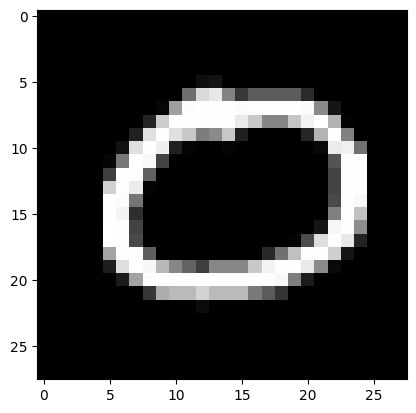

In [20]:
# Display the prediction and ground truth
print('Prediction:', pred)
print('Ground Truth:', gt_lbl)

# Visualize the input image
plt.imshow(img, cmap='gray')
plt.show()



This code snippet serves as a visual demonstration of the model's prediction capabilities and allows us to compare the predicted class with the actual ground truth label.